In [4]:
#Library
    
# Warning Ignore
import warnings
warnings.filterwarnings('ignore')

# Library 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

#data preprocessing 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#modeling
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold, GridSearchCV

from sklearn.metrics import (confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, 
                            recall_score, f1_score, accuracy_score, roc_auc_score, balanced_accuracy_score, precision_recall_fscore_support)

# Data Overview

In [5]:
df = pd.read_csv('dataset.csv')
pd.set_option('display.max_columns',None)
df.head()

,ID,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed,Num_children,Num_family,Account_length,Total_income,Age,Years_employed,Income_type,Education_type,Family_status,Housing_type,Occupation_type,Target
0,5008804,1,1,1,1,0,0,0,0,2,15,427500.0,32.868574,12.435574,Working,Higher education,Civil marriage,Rented apartment,Other,1
1,5008806,1,1,1,0,0,0,0,0,2,29,112500.0,58.793815,3.104787,Working,Secondary / secondary special,Married,House / apartment,Security staff,0
2,5008808,0,0,1,0,1,1,0,0,1,4,270000.0,52.321403,8.353354,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,0
3,5008812,0,0,1,0,0,0,1,0,1,20,283500.0,61.504343,0.000000,Pensioner,Higher education,Separated,House / apartment,Other,0
4,5008815,1,1,1,1,1,1,0,0,2,5,270000.0,46.193967,2.105450,Working,Higher education,Married,House / apartment,Accountants,0


In [6]:
# Drop id karena tidak dipakai untuk prediksi

df.drop(['ID'], axis=1, inplace=True)
df.head()

,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed,Num_children,Num_family,Account_length,Total_income,Age,Years_employed,Income_type,Education_type,Family_status,Housing_type,Occupation_type,Target
0,1,1,1,1,0,0,0,0,2,15,427500.0,32.868574,12.435574,Working,Higher education,Civil marriage,Rented apartment,Other,1
1,1,1,1,0,0,0,0,0,2,29,112500.0,58.793815,3.104787,Working,Secondary / secondary special,Married,House / apartment,Security staff,0
2,0,0,1,0,1,1,0,0,1,4,270000.0,52.321403,8.353354,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,0
3,0,0,1,0,0,0,1,0,1,20,283500.0,61.504343,0.000000,Pensioner,Higher education,Separated,House / apartment,Other,0
4,1,1,1,1,1,1,0,0,2,5,270000.0,46.193967,2.105450,Working,Higher education,Married,House / apartment,Accountants,0


In [7]:
# Identifikasi Categorical dan Numerical

numerical_columns = df.select_dtypes(include=['number']).columns

categorical_columns = df.select_dtypes(include=['object', 'category']).columns

In [8]:
# Konversi nilai float menjadi integer agar mudah dilihat

# Columns to be rounded and converted to int
columns_to_convert = ['Total_income', 'Age', 'Years_employed']

# Round and convert to int for specific columns
df[columns_to_convert] = df[columns_to_convert].round().astype(int)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9709 entries, 0 to 9708
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Gender           9709 non-null   int64 
 1   Own_car          9709 non-null   int64 
 2   Own_property     9709 non-null   int64 
 3   Work_phone       9709 non-null   int64 
 4   Phone            9709 non-null   int64 
 5   Email            9709 non-null   int64 
 6   Unemployed       9709 non-null   int64 
 7   Num_children     9709 non-null   int64 
 8   Num_family       9709 non-null   int64 
 9   Account_length   9709 non-null   int64 
 10  Total_income     9709 non-null   int32 
 11  Age              9709 non-null   int32 
 12  Years_employed   9709 non-null   int32 
 13  Income_type      9709 non-null   object
 14  Education_type   9709 non-null   object
 15  Family_status    9709 non-null   object
 16  Housing_type     9709 non-null   object
 17  Occupation_type  9709 non-null   

In [10]:
df.isnull().sum()

Gender             0
Own_car            0
Own_property       0
Work_phone         0
Phone              0
Email              0
Unemployed         0
Num_children       0
Num_family         0
Account_length     0
Total_income       0
Age                0
Years_employed     0
Income_type        0
Education_type     0
Family_status      0
Housing_type       0
Occupation_type    0
Target             0
dtype: int64

In [11]:
df.duplicated().sum()

2

In [12]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [13]:
for col in numerical_columns:
    unique_count = df[col].nunique()
    print(f"Number of unique values in column '{col}': {unique_count}")

Number of unique values in column 'Gender': 2
Number of unique values in column 'Own_car': 2
Number of unique values in column 'Own_property': 2
Number of unique values in column 'Work_phone': 2
Number of unique values in column 'Phone': 2
Number of unique values in column 'Email': 2
Number of unique values in column 'Unemployed': 2
Number of unique values in column 'Num_children': 9
Number of unique values in column 'Num_family': 10
Number of unique values in column 'Account_length': 61
Number of unique values in column 'Total_income': 263
Number of unique values in column 'Age': 49
Number of unique values in column 'Years_employed': 44
Number of unique values in column 'Target': 2


In [14]:
for col in categorical_columns:
    unique_count = df[col].nunique()
    print(f"Number of unique values in column '{col}': {unique_count}")

Number of unique values in column 'Income_type': 5
Number of unique values in column 'Education_type': 5
Number of unique values in column 'Family_status': 5
Number of unique values in column 'Housing_type': 6
Number of unique values in column 'Occupation_type': 19


In [15]:
unique_values_dict  = {}

for col in categorical_columns:
    unique_values_dict[col] = df[col].unique()

unique_values_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in unique_values_dict.items()]))

unique_values_df

,Income_type,Education_type,Family_status,Housing_type,Occupation_type
0,Working,Higher education,Civil marriage,Rented apartment,Other
1,Commercial associate,Secondary / secondary special,Married,House / apartment,Security staff
2,Pensioner,Incomplete higher,Single / not married,Municipal apartment,Sales staff
3,State servant,Lower secondary,Separated,With parents,Accountants
4,Student,Academic degree,Widow,Co-op apartment,Laborers
5,NaN,NaN,NaN,Office apartment,Managers
6,NaN,NaN,NaN,NaN,Drivers
7,NaN,NaN,NaN,NaN,Core staff
8,NaN,NaN,NaN,NaN,High skill tech staff
9,NaN,NaN,NaN,NaN,Cleaning staff


# Visualization Data

In [16]:
# Perbedaan data dengan Target 0 dan 1 

print("Data dengan target 0:", len(df[df['Target'] == 0]))
print("Data dengan target 1:", len(df[df['Target'] == 1]))

Data dengan target 0: 8424
Data dengan target 1: 1283


## Categorical Data Analysis

### Univariate 

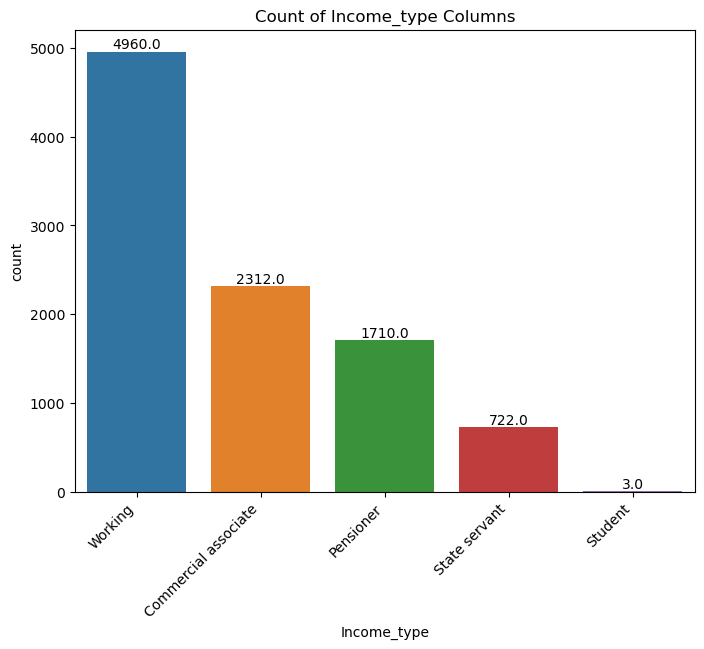

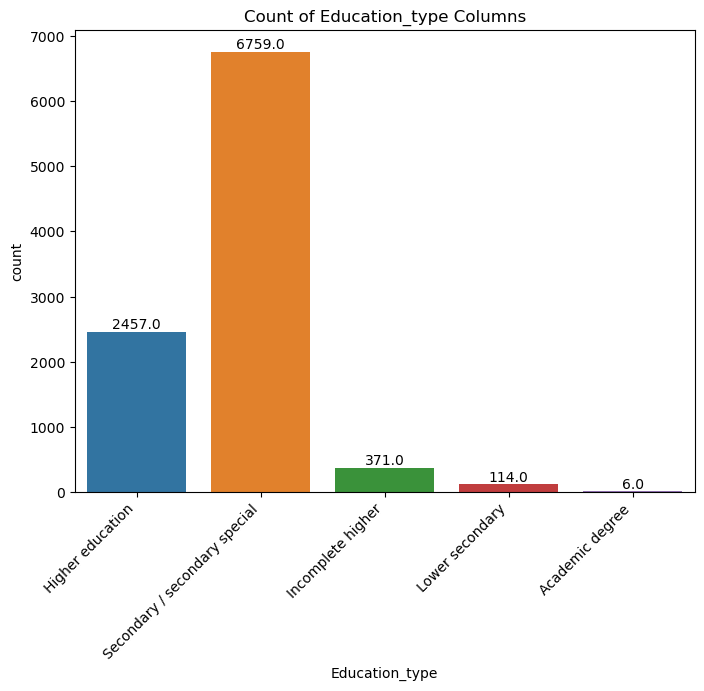

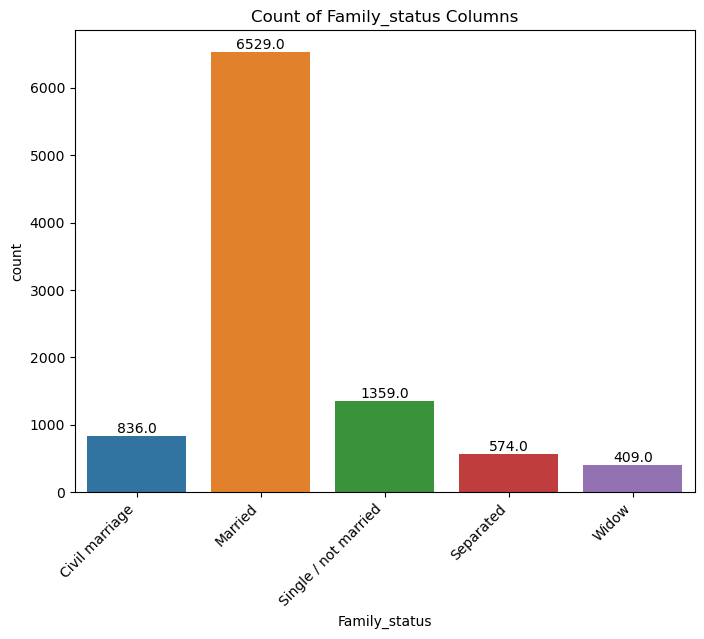

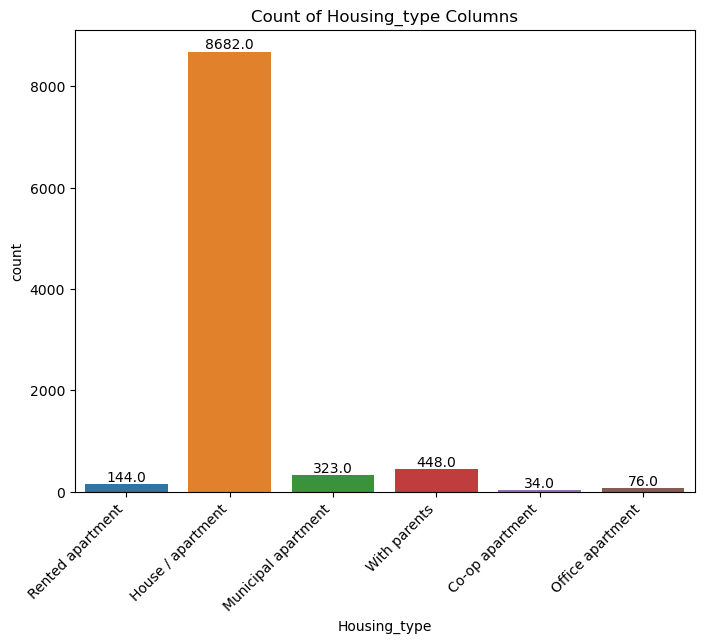

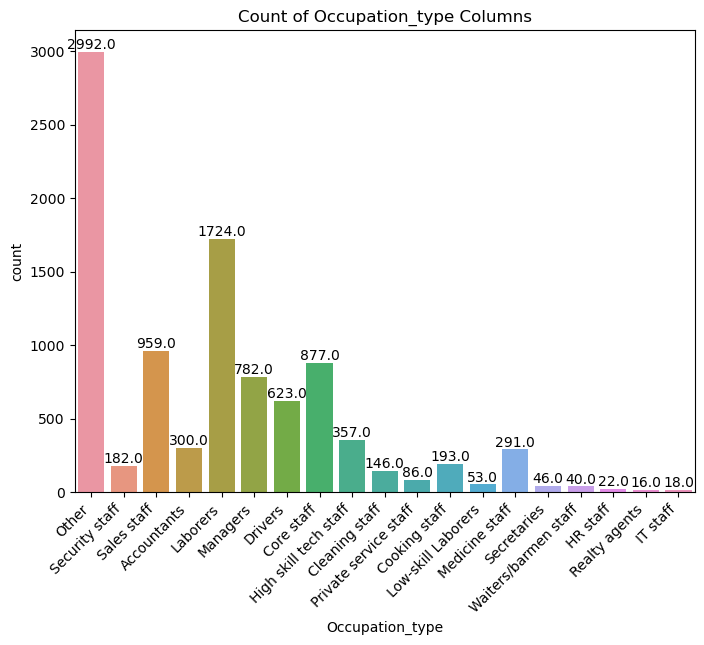

In [17]:
for col in categorical_columns:
    plt.figure(figsize=(8, 6))
    ax = sns.countplot(data=df, x=col)
    plt.title(f'Count of {col} Columns')
    plt.xticks(rotation=45, ha='right')
    
    # Adding counts on top of bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')
    
    plt.show()

### Bivariate

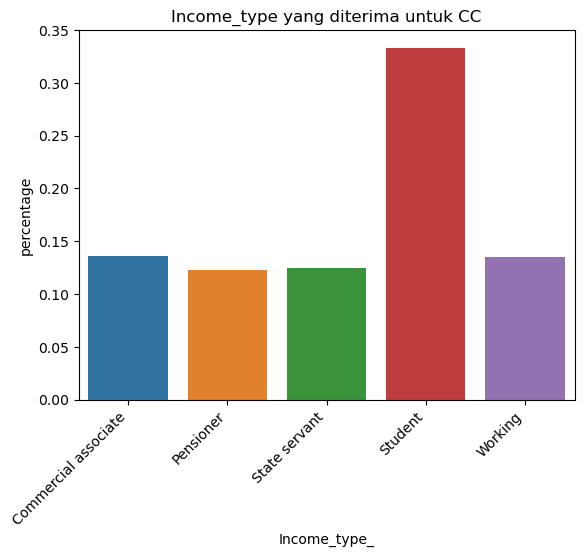

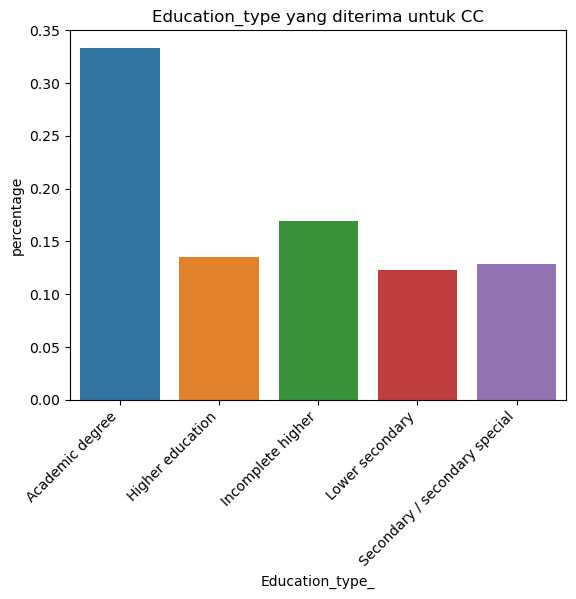

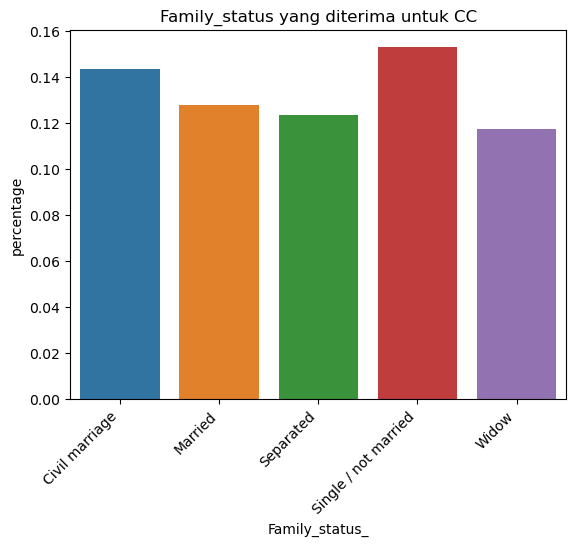

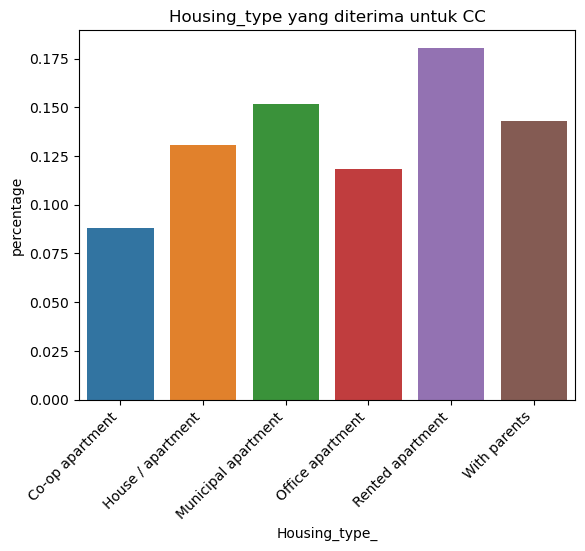

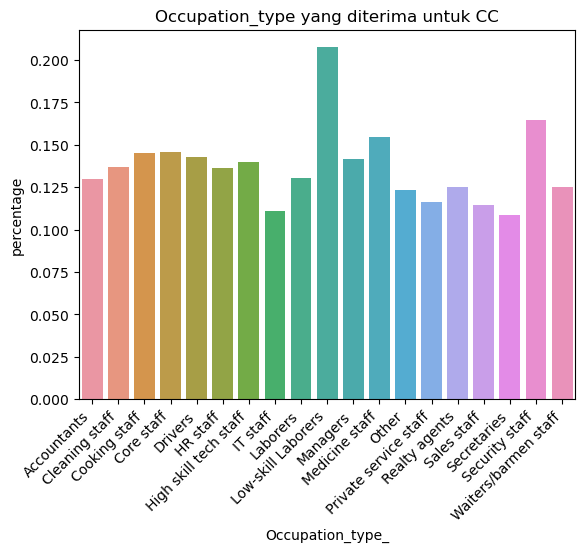

In [18]:
for col in categorical_columns:
    # Grouping by the numerical column and aggregating counts and sums
    cc = df.groupby(
        [col], as_index=False
    ).agg({
        "Target": ["count", "sum"]
    })
    
    # Renaming columns for clarity
    cc.columns = ['_'.join(x) for x in cc.columns]
    
    # Calculating the percentage of accepted CC applications for each unique value of the numerical column
    cc["percentage"] = cc['Target_sum'] / cc['Target_count']
    
    # Plotting a bar plot
    plt.title(f"{col} yang diterima untuk CC")  # Title includes the name of the numerical column
    sns.barplot(data=cc, y="percentage", x=f'{col}_', orient="v")
    plt.xticks(rotation=45, ha='right')
    
    plt.show()

## Numerical Data Analysis

### Univariate

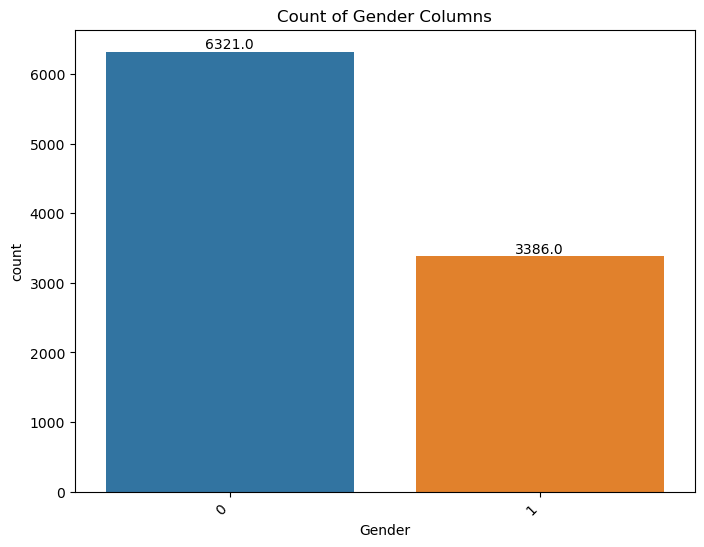

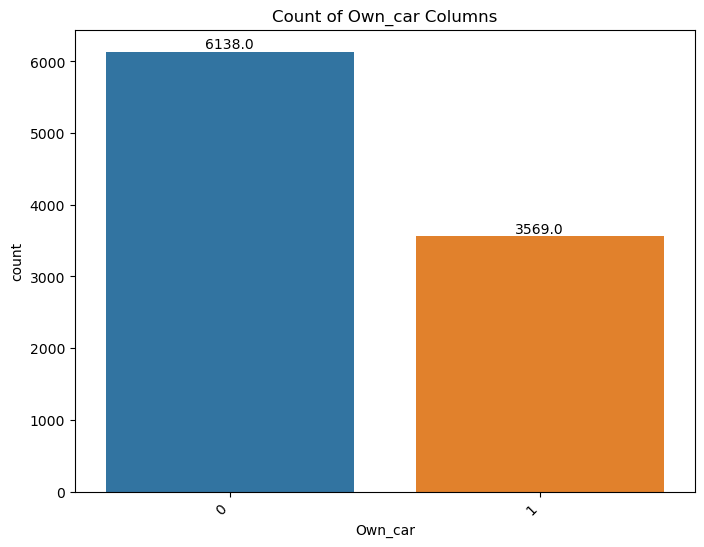

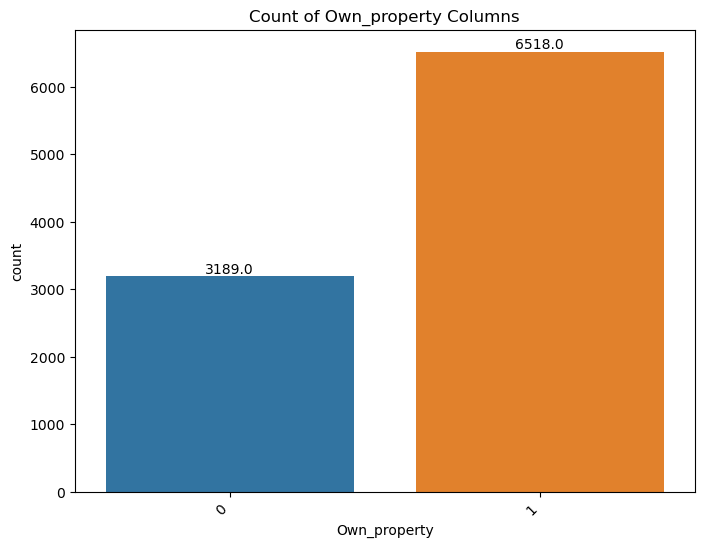

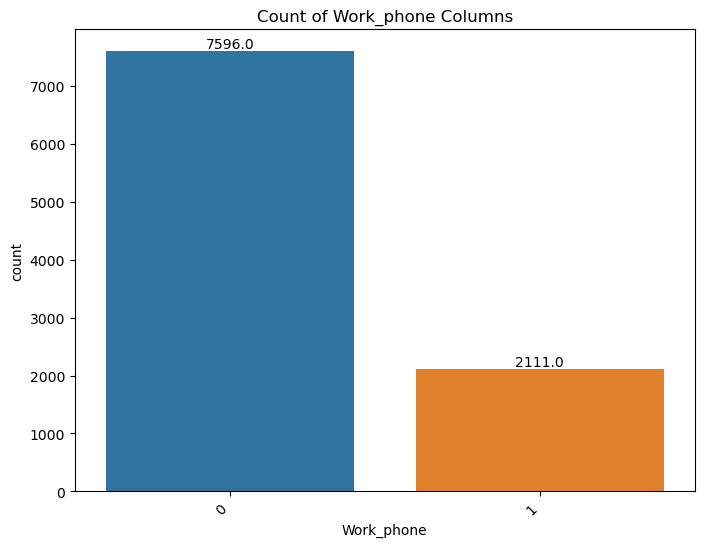

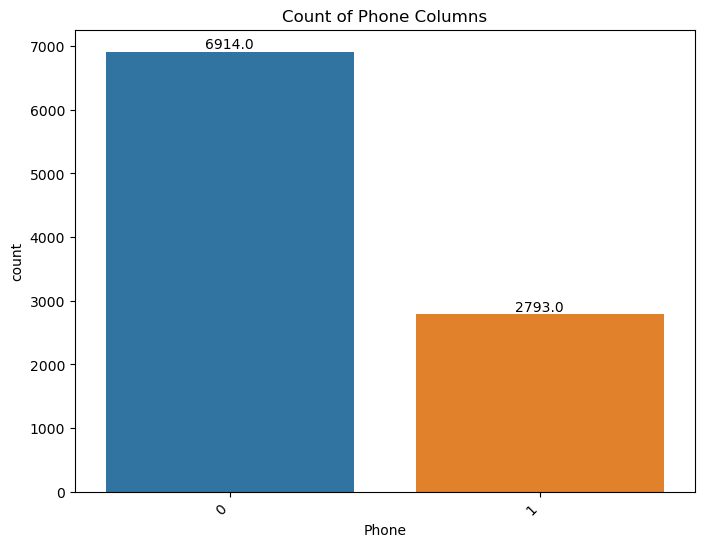

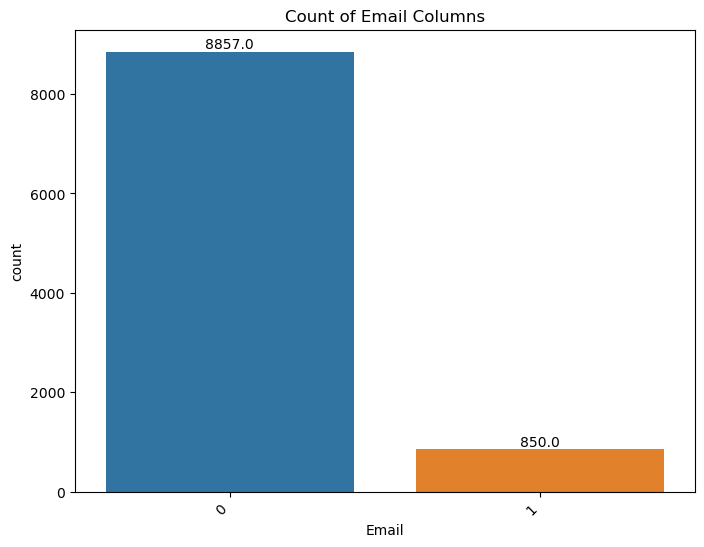

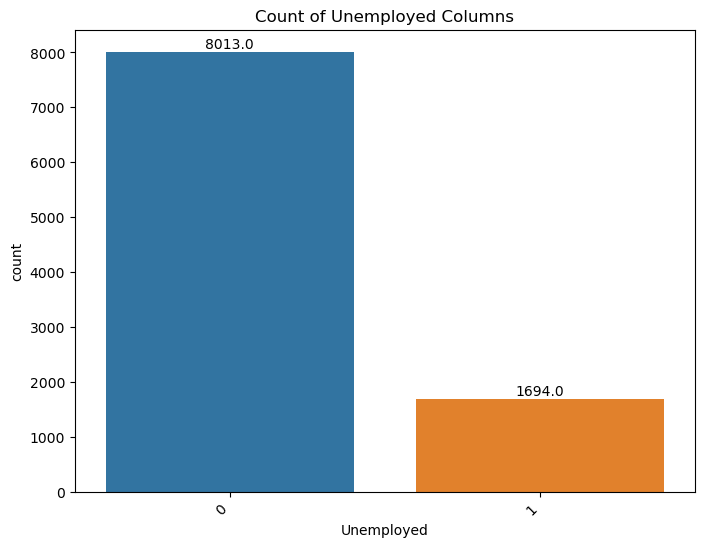

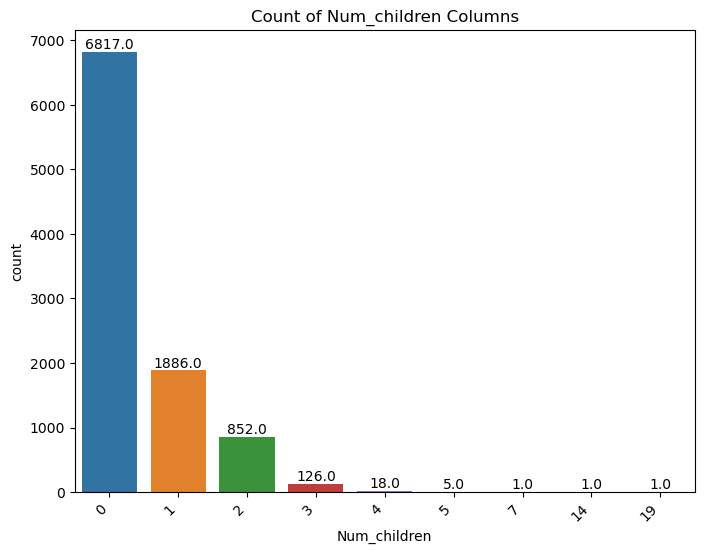

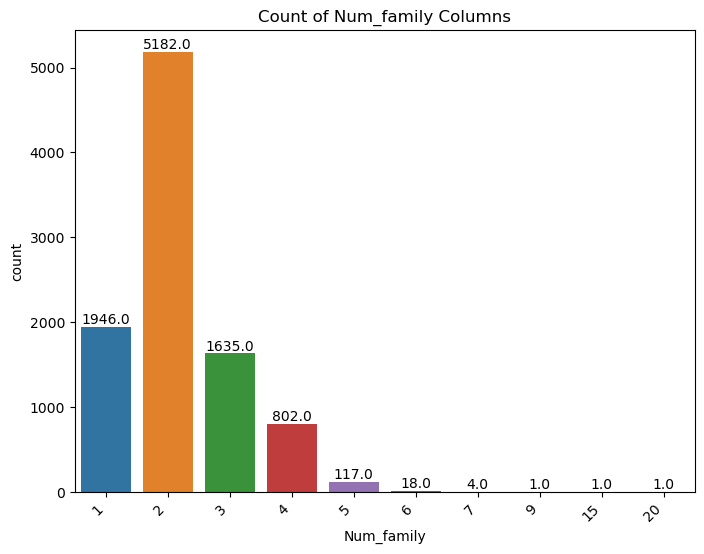

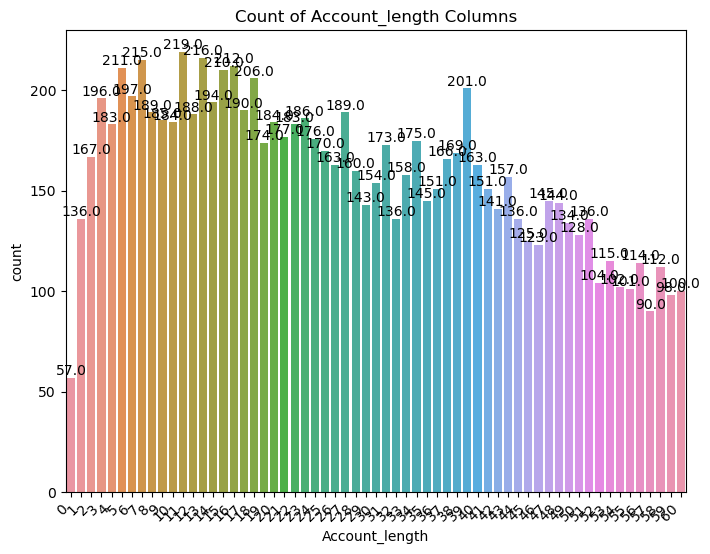

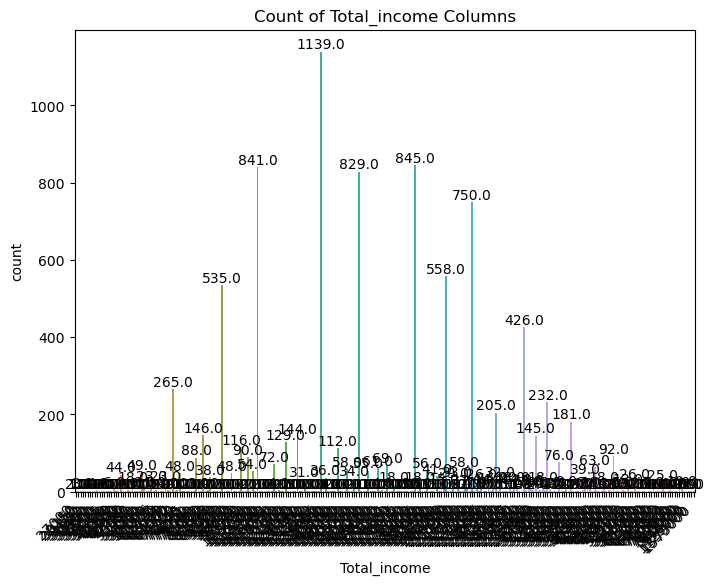

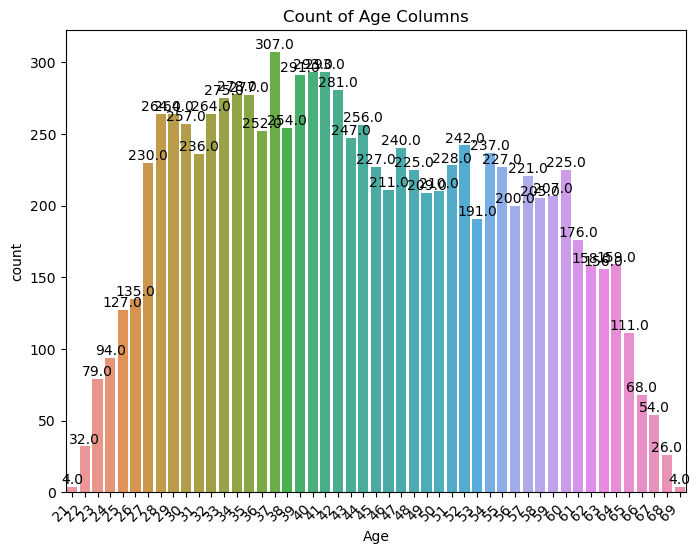

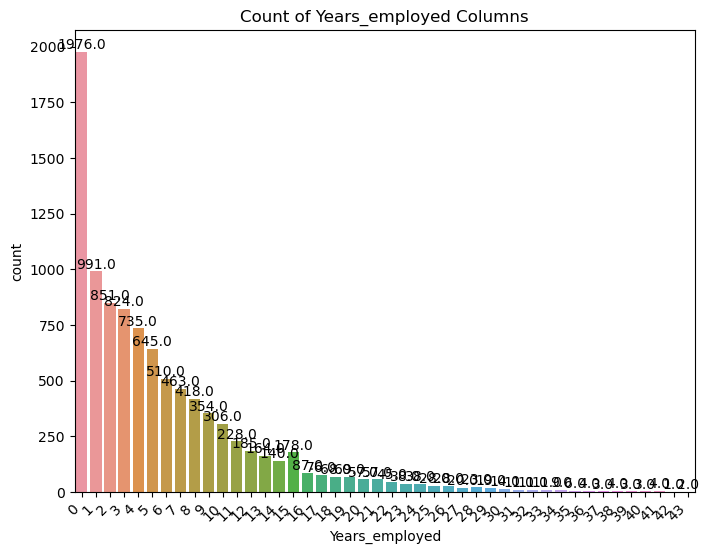

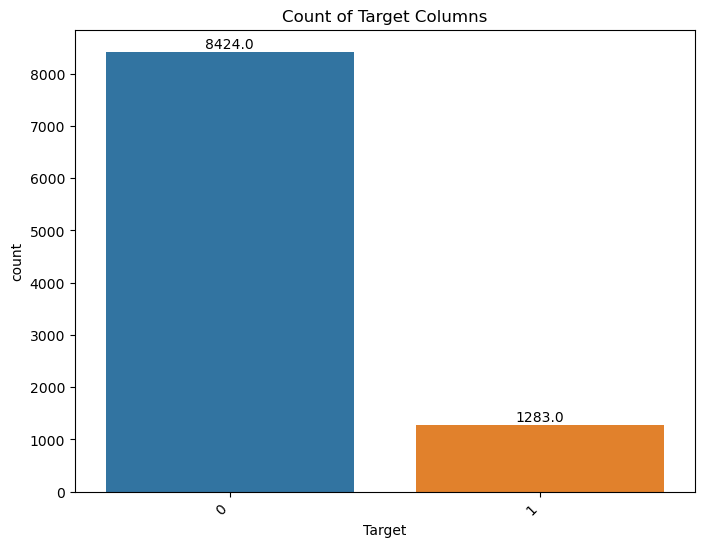

In [19]:
for col in numerical_columns:
    plt.figure(figsize=(8, 6))
    ax = sns.countplot(data=df, x=col)
    plt.title(f'Count of {col} Columns')
    plt.xticks(rotation=45, ha='right')
    
    # Adding counts on top of bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')
    
    plt.show()

### Bivariate

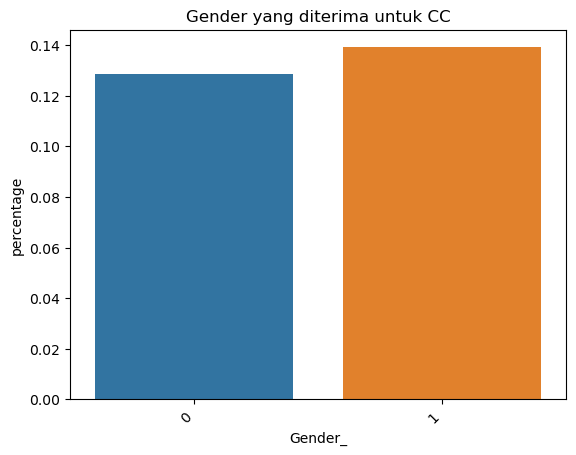

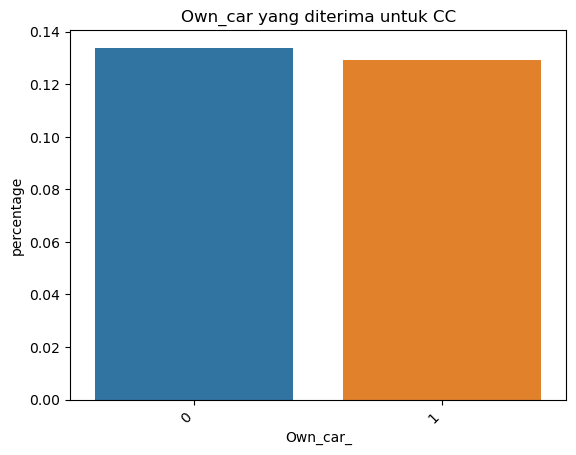

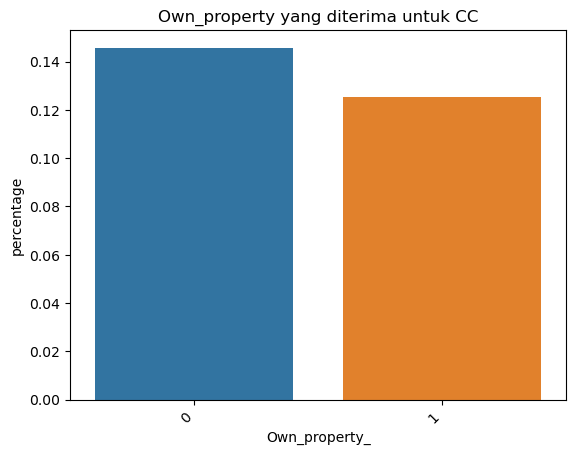

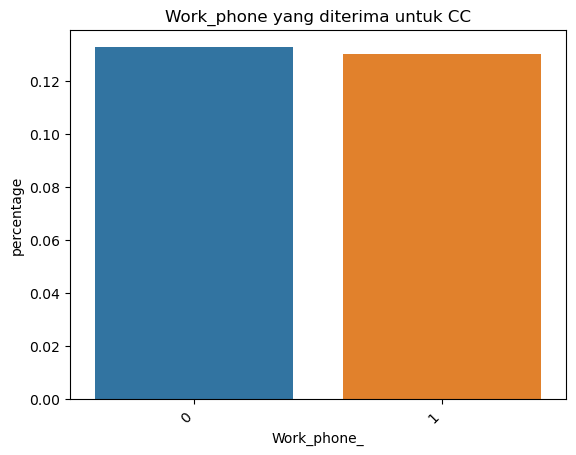

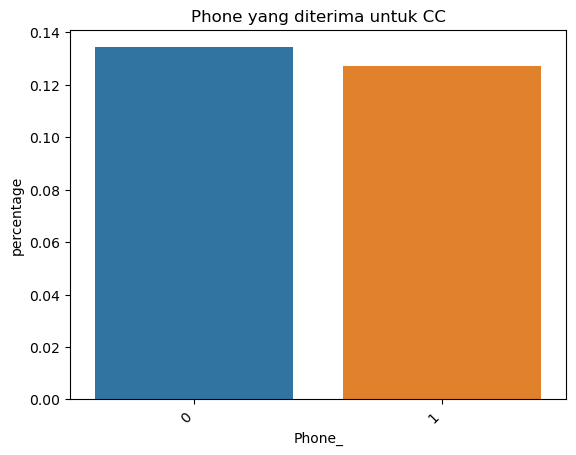

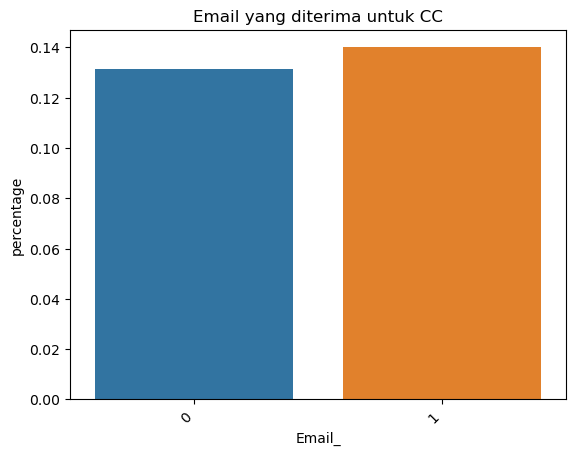

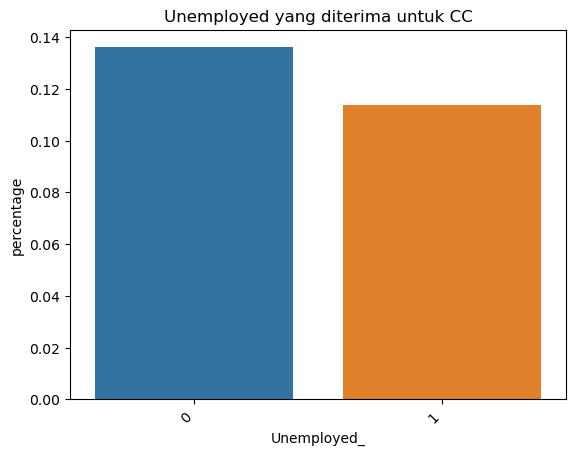

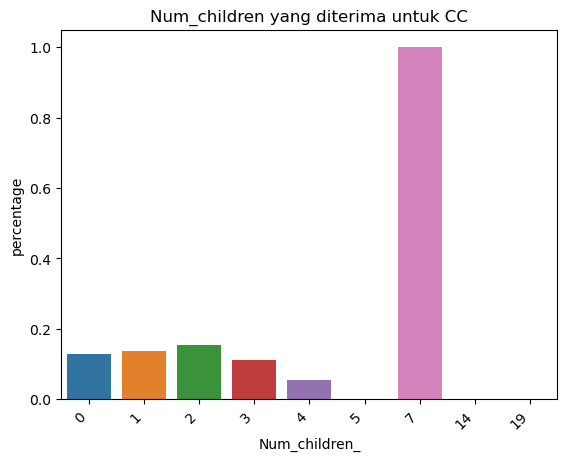

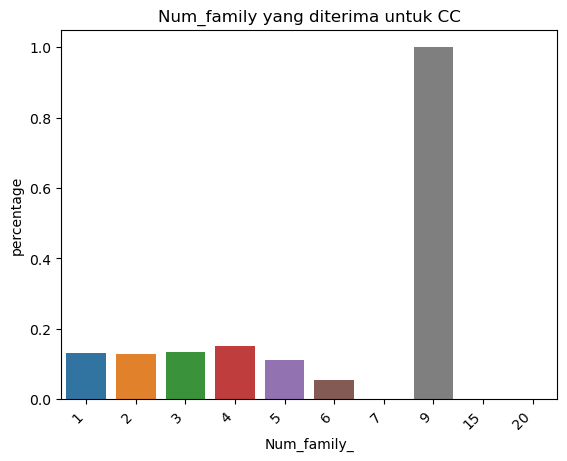

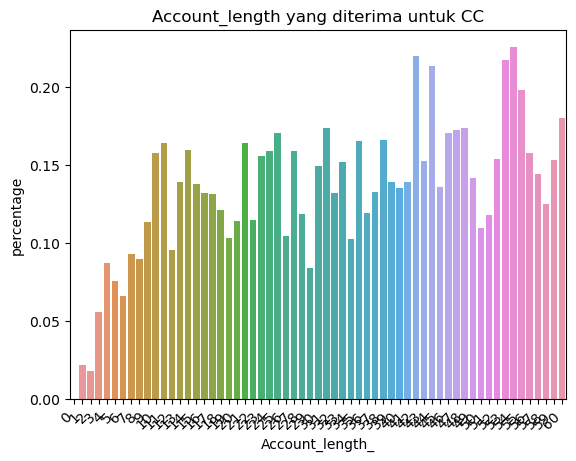

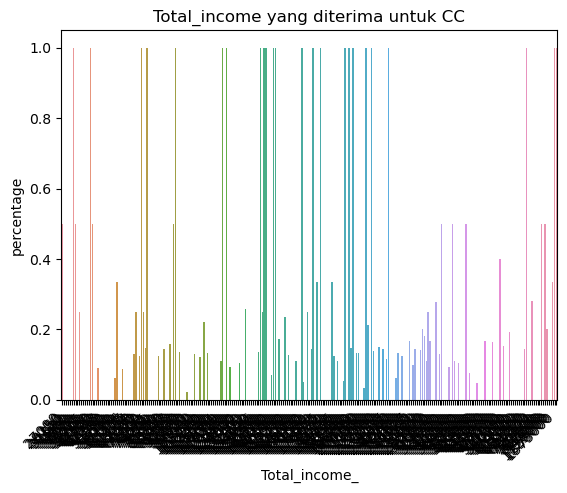

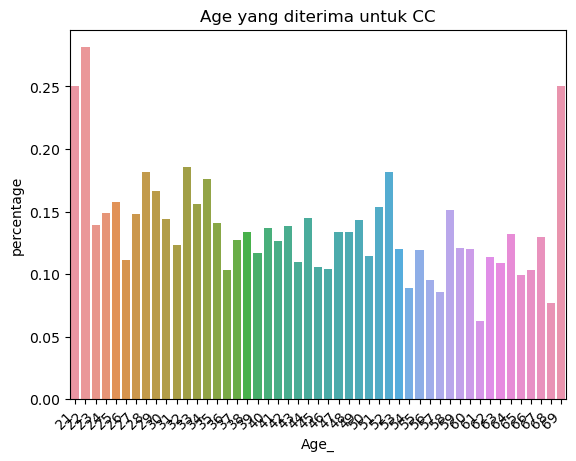

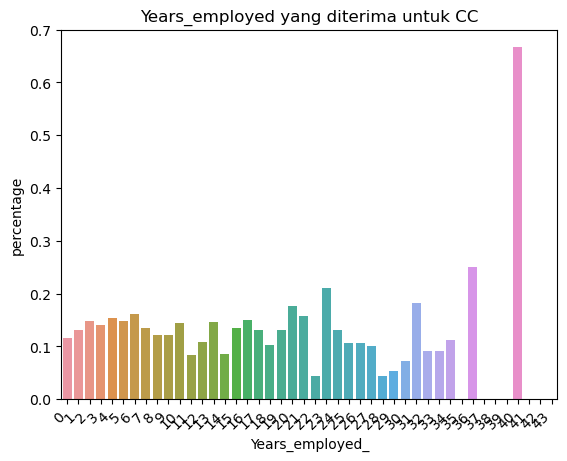

In [20]:
for col in numerical_columns:
    if col == 'Target':
        continue
    
    cc = df.groupby(
        [col],as_index=False
    ).agg({
        "Target":["count","sum"]
    })
    
    cc.columns = ['_'.join(x) for x in cc.columns]
    cc["percentage"] = cc.Target_sum/cc.Target_count
    
    plt.title(f"{col} yang diterima untuk CC")
    sns.barplot(data=cc, y="percentage", x=f'{col}_', orient="v")
    plt.xticks(rotation=45, ha='right')
    
    plt.show()

<Axes: xlabel='Age'>

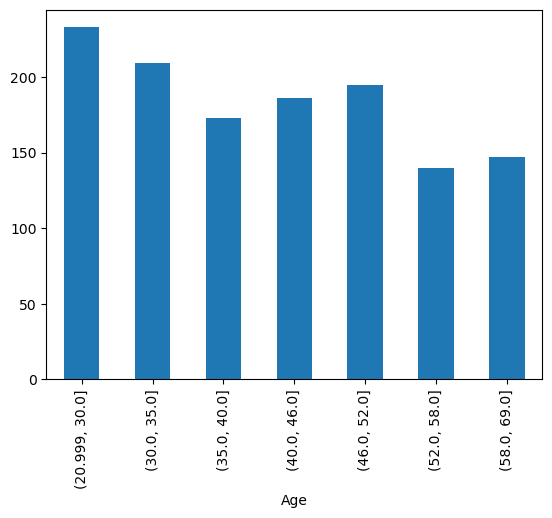

In [21]:
# Melihat Age yang diterima untuk CC
df.groupby(pd.qcut(df["Age"], q=7))["Target"].sum().plot(kind="bar")

<Axes: xlabel='Total_income'>

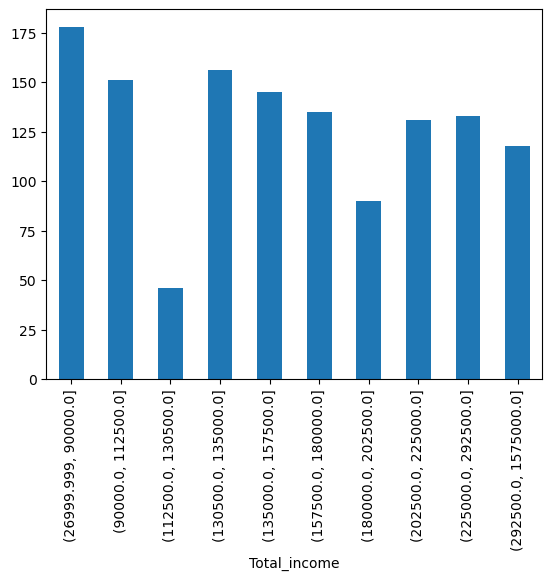

In [22]:
# Melihat Income yang diterima untuk CC

df.groupby(pd.qcut(df["Total_income"], q=10))["Target"].sum().plot(kind="bar")

<Axes: xlabel='Account_length'>

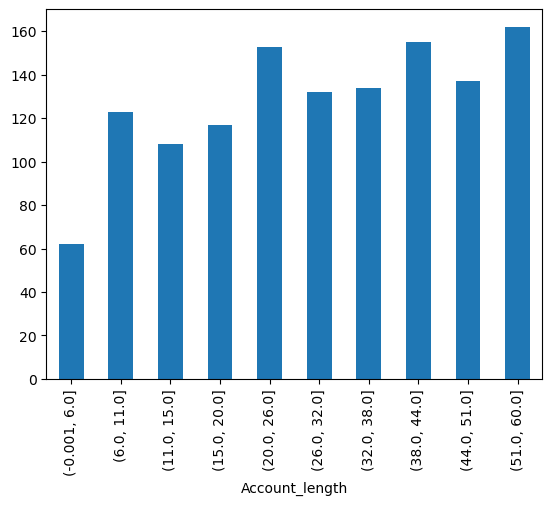

In [23]:
# Melihat Account Length yang diterima untuk CC

df.groupby(pd.qcut(df["Account_length"], q=10))["Target"].sum().plot(kind="bar")

# Proeprocessing

In [24]:
df

,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed,Num_children,Num_family,Account_length,Total_income,Age,Years_employed,Income_type,Education_type,Family_status,Housing_type,Occupation_type,Target
0,1,1,1,1,0,0,0,0,2,15,427500,33,12,Working,Higher education,Civil marriage,Rented apartment,Other,1
1,1,1,1,0,0,0,0,0,2,29,112500,59,3,Working,Secondary / secondary special,Married,House / apartment,Security staff,0
2,0,0,1,0,1,1,0,0,1,4,270000,52,8,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,0
3,0,0,1,0,0,0,1,0,1,20,283500,62,0,Pensioner,Higher education,Separated,House / apartment,Other,0
4,1,1,1,1,1,1,0,0,2,5,270000,46,2,Working,Higher education,Married,House / apartment,Accountants,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9704,0,0,0,0,0,0,0,0,2,20,180000,56,1,Pensioner,Secondary / secondary special,Civil marriage,Municipal apartment,Laborers,1
9705,0,0,1,1,1,0,0,0,2,19,112500,43,7,Commercial associate,Secondary / secondary special,Married,House / apartment,Other,1
9706,1,1,1,0,0,0,0,0,2,21,90000,52,5,Working,Secondary / secondary special,Married,House / apartment,Other,1
9707,0,0,1,0,1,1,0,0,2,32,157500,34,4,Pensioner,Higher education,Married,House / apartment,Medicine staff,1


In [25]:
# Define preprocessing for numerical and categorical columns using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numerical_columns),  # Impute missing values with mean
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

# Fit and transform the data
transformed_data = preprocessor.fit_transform(df)

# Get the names of the one-hot encoded categorical features
encoded_cat_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)

# Create a DataFrame for the transformed categorical features with original column names
transformed_categorical_df = pd.DataFrame(transformed_data[:, len(numerical_columns):], columns=encoded_cat_columns)

# Concatenate the transformed categorical DataFrame with the original numerical DataFrame
transformed_df = pd.concat([pd.DataFrame(transformed_data[:, :len(numerical_columns)], columns=numerical_columns), transformed_categorical_df], axis=1)

# Display the transformed DataFrame
transformed_df.head()

,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed,Num_children,Num_family,Account_length,Total_income,Age,Years_employed,Target,Income_type_Commercial associate,Income_type_Pensioner,Income_type_State servant,Income_type_Student,Income_type_Working,Education_type_Academic degree,Education_type_Higher education,Education_type_Incomplete higher,Education_type_Lower secondary,Education_type_Secondary / secondary special,Family_status_Civil marriage,Family_status_Married,Family_status_Separated,Family_status_Single / not married,Family_status_Widow,Housing_type_Co-op apartment,Housing_type_House / apartment,Housing_type_Municipal apartment,Housing_type_Office apartment,Housing_type_Rented apartment,Housing_type_With parents,Occupation_type_Accountants,Occupation_type_Cleaning staff,Occupation_type_Cooking staff,Occupation_type_Core staff,Occupation_type_Drivers,Occupation_type_HR staff,Occupation_type_High skill tech staff,Occupation_type_IT staff,Occupation_type_Laborers,Occupation_type_Low-skill Laborers,Occupation_type_Managers,Occupation_type_Medicine staff,Occupation_type_Other,Occupation_type_Private service staff,Occupation_type_Realty agents,Occupation_type_Sales staff,Occupation_type_Secretaries,Occupation_type_Security staff,Occupation_type_Waiters/barmen staff
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,15.0,427500.0,33.0,12.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,29.0,112500.0,59.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,4.0,270000.0,52.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,20.0,283500.0,62.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,5.0,270000.0,46.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
y = transformed_df['Target']
X = transformed_df.drop(columns='Target')

In [27]:
# Cek Distribusi untuk target value

print("Banyak data pada Y :", len(y), "\n")
print(y.value_counts()/len(y))

Banyak data pada Y : 9707 

Target
0.0    0.867827
1.0    0.132173
Name: count, dtype: float64


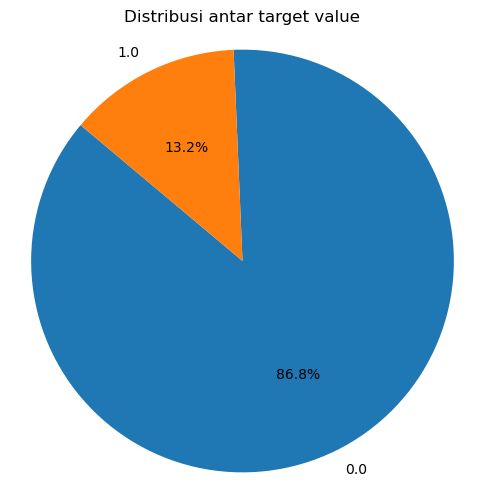

In [28]:
# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(y.value_counts(), labels=y.value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Distribusi antar target value')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [29]:
rus = RandomUnderSampler(sampling_strategy=0.7, random_state=42)
X, y = rus.fit_resample(X, y)

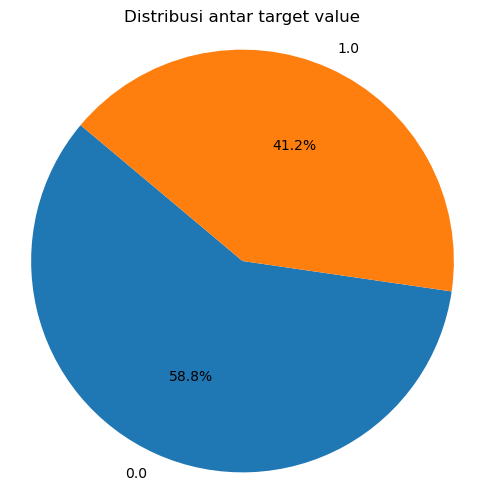

In [30]:
# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(y.value_counts(), labels=y.value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Distribusi antar target value')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2492, 53)
X_test shape: (623, 53)
y_train shape: (2492,)
y_test shape: (623,)


# Modeling

## XGBoost

In [33]:
# Define the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Train the classifier
xgb_classifier.fit(X_train, y_train)

# Predictions on the test set
y_pred = xgb_classifier.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

In [34]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.5601926163723917
Precision: 0.4224137931034483
Recall: 0.4117647058823529
F1 Score: 0.4170212765957447
ROC AUC Score: 0.5318563789152024


## Hyperparameter

In [35]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Define the parameter space
param_space = {
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(1, 10),
}

# Define the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Perform hyperparameter tuning using Bayesian optimization
bayes_search = BayesSearchCV(
    estimator=xgb_classifier,
    search_spaces=param_space,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    n_iter=50,  # Number of parameter settings that are sampled
    verbose=0,
    random_state=42
)

# Fit the model
bayes_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = bayes_search.best_params_

In [36]:
# Initialize XGBoost classifier with the best parameters
best_xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    **best_params  # Use the best parameters obtained from grid search
)

# Train the classifier
best_xgb_classifier.fit(X_train, y_train)

# Predictions on the test set
y_pred = best_xgb_classifier.predict(X_test)

In [37]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.5858747993579454
Precision: 0.4576271186440678
Recall: 0.453781512605042
F1 Score: 0.45569620253164556
ROC AUC Score: 0.5606569900687547


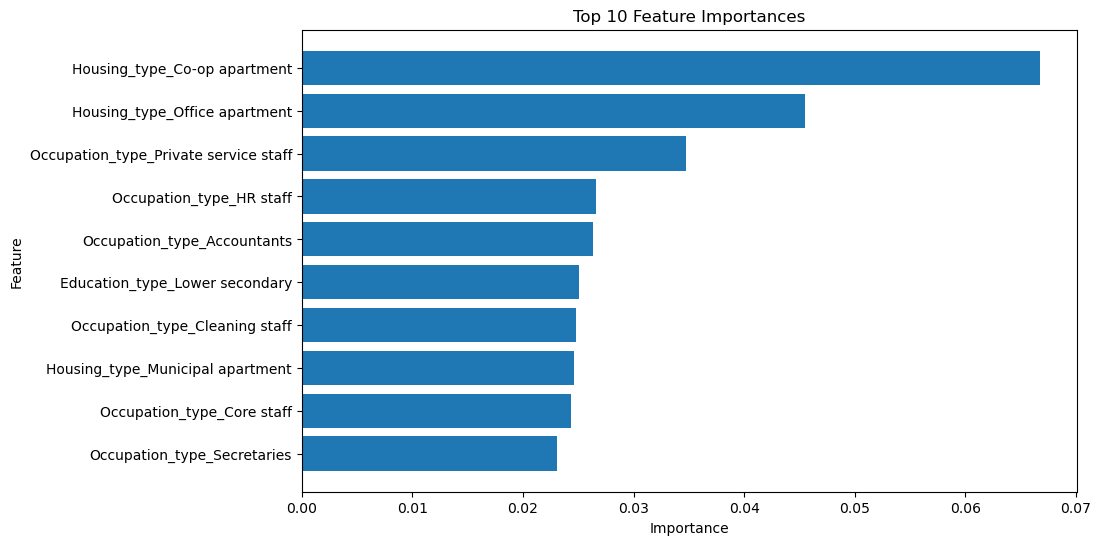

In [38]:
# Assume xgb_classifier is your trained XGBoost model
importances = best_xgb_classifier.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top 10 most important features
top_10_features = feature_importance_df.head(10)

# Plotting top 10 feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()